# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
from scipy.optimize import minimize

sns.set_style('darkgrid')

In [12]:
# Choose stocks from different industries
tickers = ['AAPL', 'TSLA', 'JNJ', 'NVDA', 'JPM', 'WMT', 'XOM', 'T']
#tickers = ['AAPL', 'MSFT', 'GOOG', 'TSLA', 'NVDA', 'JNJ', 'JPM', 'WMT', 'XOM', 'T']

start_date = dt.datetime.today() - dt.timedelta(days=2*365)
end_date = dt.datetime.today()

# Download Adjusted Close prices
data = yf.download(tickers, start=start_date, end=end_date)['Close']
data.head()

[*********************100%***********************]  8 of 8 completed


Ticker,AAPL,JNJ,JPM,NVDA,T,TSLA,WMT,XOM
Date,,,,,,,,
2023-06-16,183.086868,154.219971,136.397659,42.665741,14.246064,260.540009,50.597305,98.132179
2023-06-20,183.175980,154.126083,135.702621,43.781052,13.997689,274.450012,50.151611,95.882599
2023-06-21,182.136414,153.891342,135.502716,43.018528,13.846891,259.459991,50.249218,96.956047
2023-06-22,185.146255,155.525269,132.893921,42.998535,13.820279,264.609985,50.668877,96.423988
2023-06-23,184.829453,155.393799,132.198898,42.183041,13.704962,256.600006,50.574539,95.583908


In [13]:
# Daily log returns
returns = np.log(data / data.shift(1)).dropna()
returns.head()

Ticker,AAPL,JNJ,JPM,NVDA,T,TSLA,WMT,XOM
Date,,,,,,,,
2023-06-20,0.000487,-0.000609,-0.005109,0.025805,-0.017588,0.052013,-0.008848,-0.023191
2023-06-21,-0.005691,-0.001524,-0.001474,-0.017570,-0.010832,-0.056167,0.001944,0.011133
2023-06-22,0.016390,0.010561,-0.019440,-0.000465,-0.001924,0.019654,0.008317,-0.005503
2023-06-23,-0.001713,-0.000846,-0.005244,-0.019148,-0.008379,-0.030739,-0.001864,-0.008751
2023-06-26,-0.007582,-0.011243,0.002446,-0.038078,0.011583,-0.062514,-0.002641,0.018289


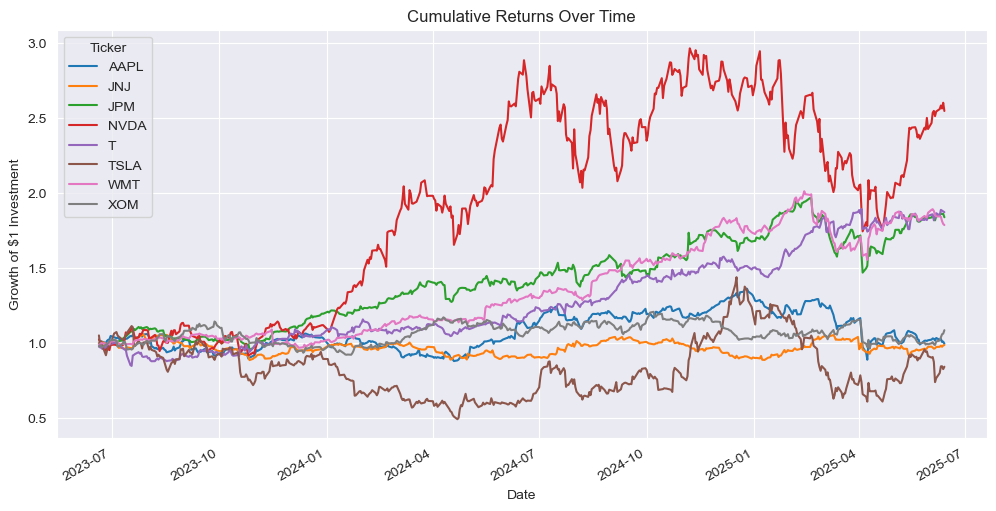

In [14]:
cumulative_returns = (1 + returns).cumprod()
cumulative_returns.plot(figsize=(12, 6))
plt.title("Cumulative Returns Over Time")
plt.ylabel("Growth of $1 Investment")
plt.show()

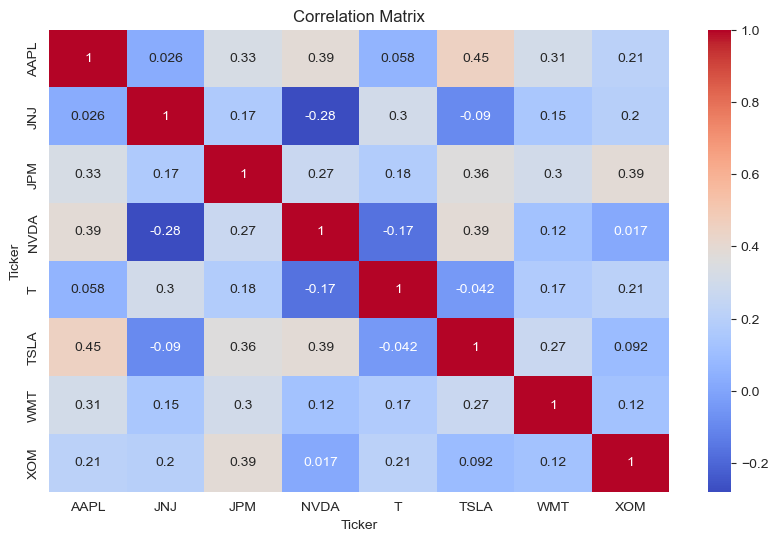

Ticker
TSLA    0.631753
NVDA    0.517721
AAPL    0.273624
T       0.234066
JPM     0.233343
XOM     0.224337
WMT     0.207678
JNJ     0.176060
dtype: float64

In [15]:
annual_volatility = returns.std() * np.sqrt(252)
correlation_matrix = returns.corr()

# Show as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

annual_volatility.sort_values(ascending=False)

In [16]:
# Annualized covariance matrix
cov_matrix = returns.cov() * 252

def portfolio_volatility(weights, cov_matrix=cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns) * 252

def get_constraints(min_w=0.05, max_w=0.35):
    return (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: np.min(x) - min_w},
        {'type': 'ineq', 'fun': lambda x: max_w - np.max(x)}
    )

mean_daily_returns = returns.mean()

In [17]:
n_assets = len(tickers)
init_guess = np.array([1/n_assets] * n_assets)

constraints = get_constraints(min_w=0.05, max_w=0.35)

low_risk_result = minimize(portfolio_volatility, init_guess, constraints=constraints)
low_risk_weights = low_risk_result.x

# Show portfolio
print("Low-Risk Portfolio Weights:")
for t, w in zip(tickers, low_risk_weights):
    print(f"{t}: {w:.4f}")
print(f"Portfolio Volatility: {low_risk_result.fun:.4f}")

Low-Risk Portfolio Weights:
AAPL: 0.0501
TSLA: 0.3500
JNJ: 0.0502
NVDA: 0.0520
JPM: 0.1506
WMT: 0.0500
XOM: 0.1573
T: 0.1399
Portfolio Volatility: 0.1247


In [18]:
def neg_portfolio_volatility(weights, cov_matrix=cov_matrix):
    return -np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def neg_return(weights, mean_returns=mean_daily_returns):
    #return -np.dot(weights, mean_returns)
    return -np.dot(weights, mean_returns) * 252

In [19]:
# Relax max weight constraint to allow concentrated positions
constraints_risky = get_constraints(min_w=0.01, max_w=0.80)

high_risk_result = minimize(neg_portfolio_volatility, init_guess, constraints=constraints_risky)
high_risk_weights = high_risk_result.x

print("High-Risk Portfolio Weights:")
for t, w in zip(tickers, high_risk_weights):
    print(f"{t}: {w:.4f}")
print(f"Portfolio Volatility: {-high_risk_result.fun:.4f}")

High-Risk Portfolio Weights:
AAPL: 0.0100
TSLA: 0.0102
JNJ: 0.0100
NVDA: 0.1398
JPM: 0.0100
WMT: 0.8000
XOM: 0.0100
T: 0.0100
Portfolio Volatility: 0.5403


In [20]:
# Try maximizing expected return subject to less conservative bounds
constraints_return = get_constraints(min_w=0.01, max_w=0.8)

high_return_result = minimize(neg_return, init_guess, constraints=constraints_return)
high_return_weights = high_return_result.x
high_return = -high_return_result.fun
high_volatility = portfolio_volatility(high_return_weights)

print("High-Return Portfolio Weights:")
for t, w in zip(tickers, high_return_weights):
    print(f"{t}: {w:.4f}")
print(f"Portfolio Volatility: {high_volatility:.4f}")

High-Return Portfolio Weights:
AAPL: 0.0422
TSLA: 0.0100
JNJ: 0.0275
NVDA: 0.3953
JPM: 0.0123
WMT: 0.1585
XOM: 0.3442
T: 0.0100
Portfolio Volatility: 0.2919


In [21]:
low_risk_ret = portfolio_return(low_risk_weights, mean_daily_returns)
high_risk_ret = portfolio_return(high_risk_weights, mean_daily_returns)
high_return_ret = portfolio_return(high_return_weights, mean_daily_returns)

print(f"Low-Risk Return: {low_risk_ret:.4f}, Volatility: {low_risk_result.fun:.4f}")
print(f"High-Risk Return: {high_risk_ret:.4f}, Volatility: {-high_risk_result.fun:.4f}")
print(f"High-Return Return: {high_return_ret:.4f}, Volatility: {portfolio_volatility(high_return_weights):.4f}")

Low-Risk Return: 0.1699, Volatility: 0.1247
High-Risk Return: 0.1857, Volatility: 0.5403
High-Return Return: 0.3820, Volatility: 0.2919
